In [ ]:
#Carga de librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from pycaret.regression import *

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# 1. Carga
url = "https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv"
df = pd.read_csv(url)
df

id             date   price  bedrooms  bathrooms  sqft_living  \
0      7129300520  20141013T000000  221900         3       1.00         1180   
1      6414100192  20141209T000000  538000         3       2.25         2570   
2      5631500400  20150225T000000  180000         2       1.00          770   
3      2487200875  20141209T000000  604000         4       3.00         1960   
4      1954400510  20150218T000000  510000         3       2.00         1680   
...           ...              ...     ...       ...        ...          ...   
21608   263000018  20140521T000000  360000         3       2.50         1530   
21609  6600060120  20150223T000000  400000         4       2.50         2310   
21610  1523300141  20140623T000000  402101         2       0.75         1020   
21611   291310100  20150116T000000  400000         3       2.50         1600   
21612  1523300157  20141015T000000  325000         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
0          5650     1.0           0     0  ...      7        1180   
1          7242     2.0           0     0  ...      7        2170   
2         10000     1.0           0     0  ...      6         770   
3          5000     1.0           0     0  ...      7        1050   
4          8080     1.0           0     0  ...      8        1680   
...         ...     ...         ...   ...  ...    ...         ...   
21608      1131     3.0           0     0  ...      8        1530   
21609      5813     2.0           0     0  ...      8        2310   
21610      1350     2.0           0     0  ...      7        1020   
21611      2388     2.0           0     0  ...      8        1600   
21612      1076     2.0           0     0  ...      7        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0                  0      1955             0    98178  47.5112 -122.257   
1                400      1951          1991    98125  47.7210 -122.319   
2                  0      1933             0    98028  47.7379 -122.233   
3                910      1965             0    98136  47.5208 -122.393   
4                  0      1987             0    98074  47.6168 -122.045   
...              ...       ...           ...      ...      ...      ...   
21608              0      2009             0    98103  47.6993 -122.346   
21609              0      2014             0    98146  47.5107 -122.362   
21610              0      2009             0    98144  47.5944 -122.299   
21611              0      2004             0    98027  47.5345 -122.069   
21612              0      2008             0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21608           1530        1509  
21609           1830        7200  
21610           1020        2007  
21611           1410        1287  
21612           1020        1357  

[21613 rows x 21 columns]

#### 1. Analisis

In [4]:
df.dtypes

id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
fig = px.histogram(df, 
                   x="price", 
                   nbins=50, 
                   title="Histograma del precio de las viviendas", 
                   labels={"price": "Precio"}, 
                   color_discrete_sequence=["skyblue"])
fig.show()
print("Promedio", df["price"].mean().round(1))
print("Minimo:",df['price'].min())
print("Q1 (25%):", df['price'].quantile(0.25))
print("Q2 (Mediana, 50%):", df['price'].quantile(0.5)) 
print("Q3 (75%):", df['price'].quantile(0.75))
print("Maximo:",df['price'].max())

Promedio 540088.1
Minimo: 75000
Q1 (25%): 321950.0
Q2 (Mediana, 50%): 450000.0
Q3 (75%): 645000.0
Maximo: 7700000


Distribución del precio: Es asimétrica a la derecha muchas casas entre 200–600k y una cola larga con propiedades de lujo por encima de 1M. Se sujiere una transformación logarítmica con el fin de reducir asimetria.

In [6]:
# 2. Limpieza y features
df['date'] = pd.to_datetime(df['date']) #Transformacion a tipo fecha
df['yr_sold'] = df['date'].dt.year #Extraccion del año de 
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int) #Crea variable si la casa fue renovada
df['age'] = df['yr_sold'] - df['yr_built'] #Edad de la casa
df['diff_sqft_living'] = df['sqft_living'] - df['sqft_living15']
df['lot_vs_living'] = df['sqft_lot'] - df['sqft_living']

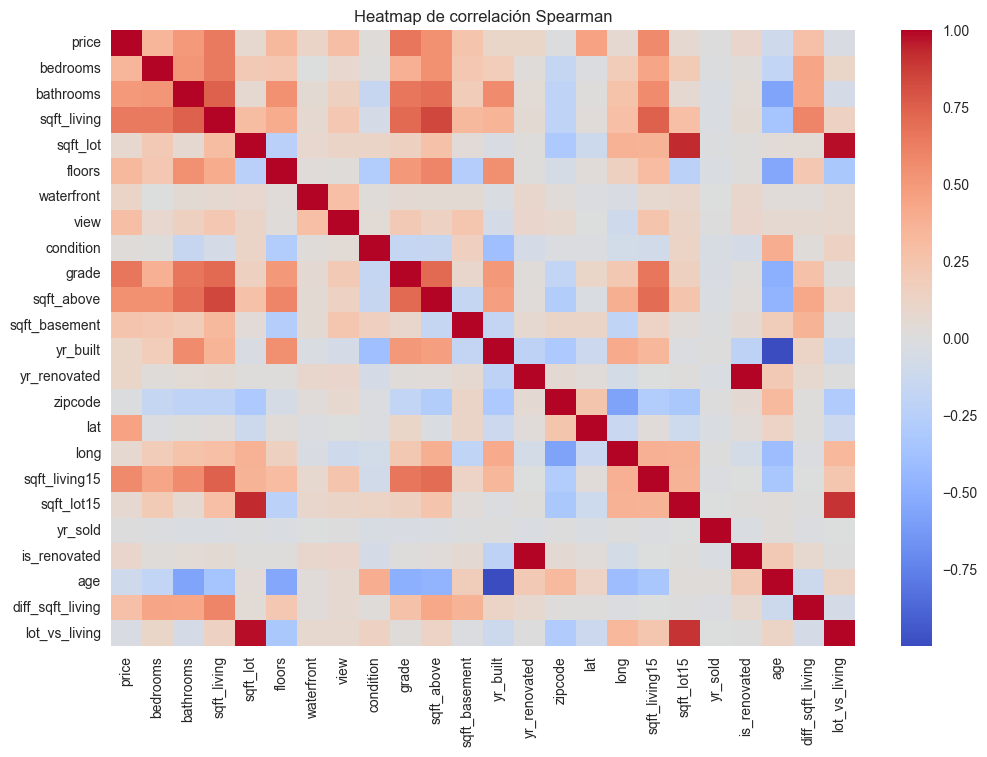

In [7]:
corr_spearman =  df.drop(columns=["id", "date"]).corr(method="spearman")
plt.figure(figsize=(12,8))
sns.heatmap(corr_spearman, cmap="coolwarm", annot=False, center=0)
plt.title("Heatmap de correlación Spearman")
plt.show()


In [8]:
corr_spearman["price"].sort_values()

age                -0.101888
lot_vs_living      -0.036436
zipcode            -0.008735
yr_sold             0.004138
condition           0.018490
sqft_lot15          0.062766
long                0.063537
sqft_lot            0.074939
is_renovated        0.101026
yr_renovated        0.101875
yr_built            0.102037
waterfront          0.115089
sqft_basement       0.251704
diff_sqft_living    0.277666
view                0.293931
floors              0.322346
bedrooms            0.344652
lat                 0.456409
bathrooms           0.497160
sqft_above          0.541752
sqft_living15       0.572290
sqft_living         0.644191
grade               0.658215
price               1.000000
Name: price, dtype: float64

Variables clave correlacionadas:

Superficie habitable (sqft_living) y calidad (grade) muestran correlaciones fuertes con el precio.

Baños y habitaciones aportan señal, aunque “bedrooms” tiende a ser menos informativo que “bathrooms” y “sqft_living”.

Ubicación (lat, long) captura diferencias de barrio—latitudes más altas (norte) y ciertas longitudes se asocian a precios mayores.

In [9]:
fig = px.scatter(df, x="yr_sold", y="price",
                 title="Precio vs Año de venta",
                 labels={"yr_sold": "Año de venta", "price": "Precio"},
                 opacity=0.6)
fig.show()


No se presenta un incremento significativo al pasar el tiempo en los precios de las casas

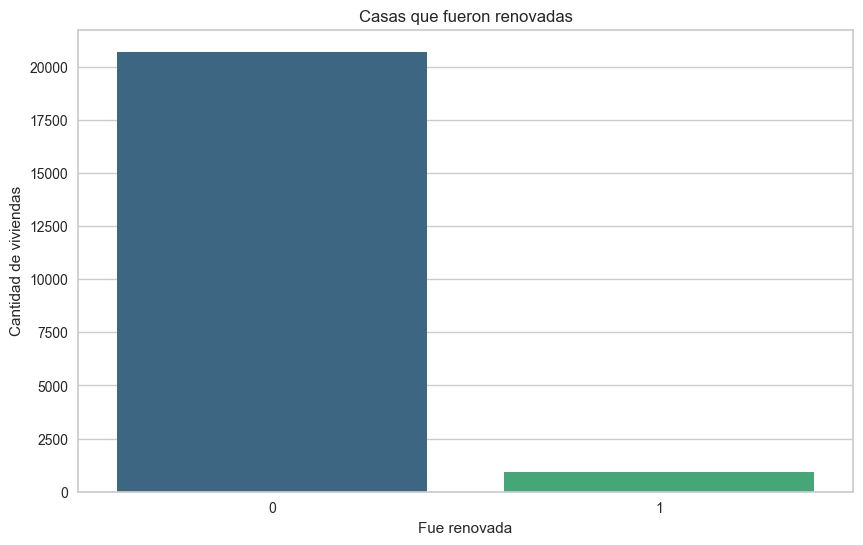

In [10]:
# Count plot de número de habitaciones
plt.figure(figsize=(10,6))
sns.countplot(x="is_renovated", data=df, palette="viridis")
plt.title("Casas que fueron renovadas")
plt.xlabel("Fue renovada")
plt.ylabel("Cantidad de viviendas")
plt.show()


In [11]:
fig = px.scatter(df, 
                 x="age", 
                 y="price",
                 title="Precio vs Edad de la casa",
                 labels={"age": "Edad de la casa", "price": "Precio", "color": "Es renovada"},
                 opacity=0.6,
                 color=df["is_renovated"].astype(str))
fig.show()


No se observa una tendencia en los valores de las casas renovadas al ser tan pocas se retira esta variables y las relacionadas

In [12]:
fig = px.scatter(df, 
                 x="diff_sqft_living", 
                 y="price",
                 title="Precio vs Diferencia de tamaño vs promedio del arrededores",
                 labels={"diff_sqft_living": "Diferencia de tamaño vs promedio del arrededores", "price": "Precio", "color": "Frente al agua"},
                 opacity=0.6,
                 color=df["waterfront"].astype(str))
fig.show()


Se puede observar una correlacion positiva en el precio al ser casa más grandes vs el promedio del "barrio" no se observa una diferencia si son frente al agua y al ser tan pocas se retira la variable

In [13]:
fig = px.scatter(df, 
                 x="sqft_lot", 
                 y="price",
                 title="Precio vs tamaño del lote",
                 labels={"sqft_lot": "tamaño del lote", "price": "Precio", "color": "Calificacion vista"},
                 opacity=0.6,
                 color=df["view"].astype(str))
fig.show()


A menor tamaño del lote donde fue construida mayor valor tiene la propiedad no se encuentra una diferencia significativa entre las calificaciones de vistas de estas

In [14]:
fig = px.scatter(df, 
                 x="sqft_living", 
                 y="price",
                 title="Precio vs Superficie habitable",
                 labels={"sqft_living": "superficie habitable", "price": "Precio", "color": "Pisos"},
                 opacity=0.6,
                 color=df["floors"].astype(str))
fig.show()


A mayor area de la casa mayor es su valor se aprecia un aumento del valor al tener mayor cantidad de pisos

In [15]:
fig = px.scatter(df, 
                 x="lot_vs_living", 
                 y="price",
                 title="Precio vs tamaño del lote sin construir",
                 labels={"lot_vs_living": "tamaño del lote sin construir", "price": "Precio", "color": "Pisos"},
                 opacity=0.6,
                 color=df["floors"].astype(str))
fig.show()


tienen un mayor valor las casas que tienen un menor despercio del lote

In [16]:
fig = px.violin(df, 
                x="bedrooms", 
                y="price", 
                box=True,  # añade boxplot dentro del violín
                points="all",  # muestra todos los puntos
                title="Distribución del precio según número de habitaciones",
                labels={"bedrooms": "Número de habitaciones", "price": "Precio"},
                color="bedrooms",
                hover_data = "id")

fig.show()


Las casas con un numero extermo de habitaciones tienen un precio menor, las de mayor valor son aquellsa con 3, 4, 5 y 6 habitaciones

In [17]:
fig = px.scatter_mapbox(df,
                        lat="lat",
                        lon="long",
                        hover_name="price",   # Muestra el precio al pasar el mouse
                        hover_data=["sqft_living", "bedrooms", "bathrooms"],
                        color="price",        # Colorear por precio
                        size="sqft_living",   # Tamaño proporcional a superficie habitable
                        color_continuous_scale="Viridis",
                        zoom=9,
                        height=600)

# Usar un estilo de mapa (requiere token de Mapbox si quieres otros estilos)
fig.update_layout(mapbox_style="open-street-map")

fig.show()


La consentracion de casas se encuentra en el suroccidente de la ciudad la concentracion de casas de alto valor se encuentra al rededor de la baiha por el centro de la ciudad

#### 2. Preprocesamiento de los datos

Se retira casa con valores outliers para mejorar la estimacion del modelo

In [18]:
df = df.loc[df["id"]!=2402100895]

Retiramos las variables con una correlacion entre -0.1 y 0.1 con el precio 
Variables no propias de la casa como sqft_living15
Se retira sqft_basement al ser complemento de sqft_above y sqft_living
No se observan valores faltanes en el dataframe

In [22]:
df['log_price'] = np.log(df['price'])

data = df.drop(columns=["id","date","price", "zipcode", "condition", "sqft_lot15", "yr_sold", "is_renovated", "yr_renovated", "yr_built", "sqft_living15", "waterfront", "sqft_basement"], errors="ignore")
print("Variables con las que vamos a modelar:", data.columns.tolist())

Variables con las que vamos a modelar: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'grade', 'sqft_above', 'lat', 'long', 'age', 'diff_sqft_living', 'lot_vs_living', 'log_price']


#### 3.Entrenamiento de modelos

Busqueda del mejor modelo mediante pycaret la cual es una herramienta que permite evaluar metricas de distintos modelos de una forma rapida

In [23]:
s = setup(data, target = 'log_price', session_id = 123)

In [ ]:
best = compare_models()
best

Initiated  . . . . . . . . . . . . . . . . . .              01:03:58
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

Escogemos el modelo LGBMRegressor debido a:

- Mejor desempeño en métricas clave:

- MAE más bajo: 0.1195 → menor error absoluto promedio.

- MSE más bajo: 0.0278 → menor error cuadrático medio.

- RMSE más bajo: 0.1666 → menor desviación estándar del error.

- R² más alto: 0.8987 → explica casi el 90% de la variabilidad de los datos.

- MAPE más bajo: 0.0092 → excelente precisión relativa.

Tiempo de entrenamiento competitivo: 1.02 segundos → más rápido que modelos como Random Forest (rf) o Gradient Boosting (gbr), que tardan más de 5 segundos.

Una vez encontrado el mejor tipo de modelo para el problema continuamos con la busqueda de la mejor conbinacion de parametros

In [29]:
X= data.drop(columns="log_price")
y= data['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm = LGBMRegressor(random_state=42)

#Grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10],
    'num_leaves': [31, 50, 100]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,                # número de folds para validación cruzada
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1            # usar todos los núcleos disponibles
)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score (MSE negativo):", grid_search.best_score_)

# Evaluar en test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("RMSE en test:", np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1962
[LightGBM] [Info] Number of data points in the train set: 17289, number of used features: 13
[LightGBM] [Info] Start training from score 13.046432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mejore

In [31]:
joblib.dump(best_model, "LGBMR.pkl")

['LGBMR.pkl']

#### 4. ¿Cómo seleccionarías viviendas atractivas para inversión?

Viviendas que su precio sea inferior al estimado por el modelo en al menos un 10% y se encuentren en una zona con gran cantidad de ventas de viviendas que ademas tenga una diferencia de tamaño superior vs promedio del arrededores para que sea diferencial ya estas casas suelen tener un mayor valor y por ultimo que haga un buen aprovechamiento del lote donde esta construida

In [43]:
df["price_pred"] = np.exp(best_model.predict(data.drop(columns=["log_price"])))
df["price_diff"] = df['price_pred'] - df['price']
df["%_price_diff"] = (df["price_pred"]-df['price'])/df['price']*100

In [52]:
df.loc[(df['%_price_diff']>10) & (df['diff_sqft_living']>0) & (df['lat']>47.49) & (df['long']>-122.24)].sort_values(by="lot_vs_living")

id       date    price  bedrooms  bathrooms  sqft_living  \
20263  3026059363 2014-10-31   575000         3       3.50         2514   
18437  3630090110 2014-10-18   690000         4       3.50         2980   
19860  9268850160 2015-02-06   293467         4       2.00         1590   
4921   3630090050 2015-02-20   690000         4       3.50         2710   
20155  3629960680 2014-09-26   395000         2       2.25         1620   
...           ...        ...      ...       ...        ...          ...   
8628    823069044 2015-03-25   833450         5       4.00         4460   
11980  3425069083 2014-06-25  1005000         4       4.50         4225   
12777  1225069038 2014-05-05  2280000         7       8.00        13540   
12387  1226069045 2014-08-27   979500         4       3.75         4133   
9714    225079036 2015-01-07   937500         4       4.00         5545   

       sqft_lot  floors  waterfront  view  ...  sqft_lot15  yr_sold  \
20263      1559     2.0           0     0  ...       10454     2014   
18437      2147     2.5           0     0  ...        2428     2014   
19860       942     3.0           0     0  ...         942     2015   
4921       2147     2.0           0     0  ...        2252     2015   
20155      1841     2.0           0     0  ...        1831     2014   
...         ...     ...         ...   ...  ...         ...      ...   
8628     269345     2.0           0     4  ...      115434     2015   
11980    284011     2.0           0     0  ...       14576     2014   
12777    307752     3.0           0     4  ...      217800     2014   
12387    361548     2.0           0     0  ...      291416     2014   
9714     871200     2.0           0     0  ...      871200     2015   

       is_renovated  age  diff_sqft_living  lot_vs_living  log_price  \
20263             0    7               424           -955  13.262125   
18437             0    8               100           -833  13.444447   
19860             0    7               200           -648  12.589520   
4921              0    8                60           -563  13.444447   
20155             0   10                90            221  12.886641   
...             ...  ...               ...            ...        ...   
8628              0   19              1790         264885  13.633329   
11980             0   29              1355         279786  13.820498   
12777             0   15              8690         294212  14.639686   
12387             0   14              2163         357415  13.794798   
9714              0   12              2125         865655  13.750972   

         price_pred     price_diff  %_price_diff  
20263  6.377673e+05   62767.317706     10.916055  
18437  7.917360e+05  101735.988810     14.744346  
19860  3.775733e+05   84106.274801     28.659534  
4921   7.753067e+05   85306.659637     12.363284  
20155  4.487355e+05   53735.517052     13.603928  
...             ...            ...           ...  
8628   1.002410e+06  168960.182093     20.272384  
11980  1.147162e+06  142161.673677     14.145440  
12777  3.179818e+06  899817.691895     39.465688  
12387  1.146221e+06  166720.538473     17.020984  
9714   1.288170e+06  350669.843310     37.404783  

[608 rows x 30 columns]

In [54]:
fig = px.scatter_mapbox(df.loc[df["id"]==3026059363],
                        lat="lat",
                        lon="long",
                        hover_name="price",   # Muestra el precio al pasar el mouse
                        hover_data=["sqft_living", "bedrooms", "bathrooms"],
                        color="price",        # Colorear por precio
                        size="sqft_living",   # Tamaño proporcional a superficie habitable
                        color_continuous_scale="Viridis",
                        zoom=9,
                        height=600)

# Usar un estilo de mapa (requiere token de Mapbox si quieres otros estilos)
fig.update_layout(mapbox_style="open-street-map")

fig.show()
print(df.loc[df["id"]==3026059363])

               id       date   price  bedrooms  bathrooms  sqft_living  \
20263  3026059363 2014-10-31  575000         3        3.5         2514   

       sqft_lot  floors  waterfront  view  ...  sqft_lot15  yr_sold  \
20263      1559     2.0           0     0  ...       10454     2014   

       is_renovated  age  diff_sqft_living  lot_vs_living  log_price  \
20263             0    7               424           -955  13.262125   

          price_pred    price_diff  %_price_diff  
20263  637767.317706  62767.317706     10.916055  

[1 rows x 30 columns]
